In [3]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.preprocessing import StandardScaler

from codecarbon import EmissionsTracker

2025-01-23 14:27:20.936955: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-23 14:27:20.937365: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-23 14:27:20.939521: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-23 14:27:20.947385: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737653240.961171    3619 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737653240.96

In [5]:
df = pd.read_csv('./final-data-pre-processed.csv', sep=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145139 entries, 0 to 145138
Data columns (total 20 columns):
 #   Column                                                 Non-Null Count   Dtype  
---  ------                                                 --------------   -----  
 0   DATA                                                   145139 non-null  object 
 1   HORA                                                   145139 non-null  object 
 2   PRECIPITAÇÃO TOTAL, HORÁRIO (mm)                       145139 non-null  float64
 3   PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)  145139 non-null  float64
 4   PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)        145139 non-null  float64
 5   PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)       145139 non-null  float64
 6   RADIACAO GLOBAL (KJ/m²)                                145139 non-null  float64
 7   TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)           145139 non-null  float64
 8   TEMPERATURA DO PONTO DE ORVALHO (°

In [6]:
X_prec = df[[
       'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)',
       'PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)',
       'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)',
       'RADIACAO GLOBAL (KJ/m²)',
       'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)',
       'TEMPERATURA DO PONTO DE ORVALHO (°C)',
       'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)',
       'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)',
       'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)',
       'UMIDADE RELATIVA DO AR, HORARIA (%)',
       'VENTO, DIREÇÃO HORARIA (gr) (° (gr))', 
       'VENTO, RAJADA MAXIMA (m/s)',
       'VENTO, VELOCIDADE HORARIA (m/s)'
    ]]

y_prec = df[['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)']]

In [4]:
X_temp = df[[
       'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)',
       'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)',
       'PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)',
       'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)',
       'RADIACAO GLOBAL (KJ/m²)',
       'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)',
       'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)',
       'UMIDADE RELATIVA DO AR, HORARIA (%)',
       'VENTO, DIREÇÃO HORARIA (gr) (° (gr))', 
       'VENTO, RAJADA MAXIMA (m/s)',
       'VENTO, VELOCIDADE HORARIA (m/s)'
    ]]

y_temp = df[['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)']]

In [10]:
def split_train_test(X, y, train_size):
    X_train, X_test = X[:round(X.shape[0]*train_size)], X[round(X.shape[0]*train_size):]
    y_train, y_test = y[:round(y.shape[0]*train_size)], y[round(y.shape[0]*train_size):]

    return X_train, X_test, y_train, y_test

def plot_prediction_over_time(y_test, predictions, timestamps, start_date=None, end_date=None, save=False):
    timestamps = pd.to_datetime(timestamps)

    data = pd.DataFrame({
        'Timestamp': timestamps,
        'Actual': y_test,
        'Predicted': predictions
    })

    if start_date:
        data = data[data['Timestamp'] >= pd.to_datetime(start_date)]
    if end_date:
        data = data[data['Timestamp'] <= pd.to_datetime(end_date)]

    plt.figure(figsize=(12, 6))
    plt.plot(data['Timestamp'], data['Actual'], label='Actual Values', color='blue', linewidth=2)
    plt.plot(data['Timestamp'], data['Predicted'], label='Predicted Values', color='orange', linewidth=2)
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.title('Actual vs. Predicted Values Over Time')
    plt.legend()
    plt.grid(True)

    
    if save: 
        plt.savefig(save)
        
    plt.show()


def plot_real_vs_predicted(y_test, predictions, save=False):
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, predictions, alpha=0.7, color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', linewidth=2, label="Ideal Fit")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Real vs Predicted Values")
    plt.legend()
    plt.grid(True)

    if save: 
        plt.savefig(save)
    
    plt.show()

## mlp temperature

In [7]:
scaler_X = StandardScaler()
X_temp_normalized = scaler_X.fit_transform(X_temp)

scaler_y = StandardScaler()
y_temp_normalized = scaler_y.fit_transform(y_temp)

NameError: name 'X_temp' is not defined

In [7]:
X_temp_train, X_temp_test, y_temp_train, y_temp_test = split_train_test(X_temp, y_temp, train_size=0.8)

In [8]:
model = tf.keras.Sequential([
    Dense(X_temp.shape[1], activation='relu', input_shape=(X_temp.shape[1], )),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

/usr/share/jupyter/kernels/tf-p3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-01-23 10:10:43.887518: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [9]:
tracker = EmissionsTracker(
    project_name="mlp temperature train",
    output_file='./codecarbon_emissions.csv',
    log_level = "critical"
)

tracker.start()


model.compile(
    loss='mean_squared_error',
    optimizer='adam',
    metrics=['mean_absolute_error'] 
)

model.summary()

model.fit(X_temp_train, y_temp_train, epochs=100, batch_size=32, verbose=1)

loss, mae = model.evaluate(X_temp_test, y_temp_test, verbose=2)
print(f"Loss (MSE): {loss}")
print(f"Mean Absolute Error: {mae}")


rmse = np.sqrt(loss)
print(f"Root Mean Squared Error (RMSE): {rmse}")


emissions: float = tracker.stop()
print(f"emissions={emissions}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 11)             │           132 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 549 (2.14 KB)

 Trainable params: 549 (2.14 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
3629/3629 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 246.8932 - mean_absolute_error: 6.2692    
Epoch 2/100
3629/3629 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 8.5660 - mean_absolute_error: 2.3380
Epoch 3/100
3629/3629 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 8.2020 - mean_absolute_error: 2.2950  
Epoch 4/100
3629/3629 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 7.7655 - mean_absolute_error: 2.2362
Epoch 5/100
3629/3629 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 7.2382 - mean_absolute_error: 2.1638  
Epoch 6/100
3629/3629 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 7.0752 - mean_absolute_error: 2.1411  
Epoch 7/100
3629/3629 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 6.8845 - mean_absolute_error: 2.1122  
Epoch 8/100
3629/3629 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 6.8706 - mean_absolute_error: 2.1183   
Epoch 9/100
3629/3629 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 6.8939 - mean_absolute_error: 2.1183
Epoch 10/100
3629/3629 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 6.7109 - mean_absol

In [10]:
y_temp_pred_probs = model.predict(X_temp_test, verbose=2)

908/908 - 1s - 563us/step


In [11]:
y_temp_test_flat = y_temp_test.values.flatten()
y_temp_pred_flat = y_temp_pred_probs.flatten()

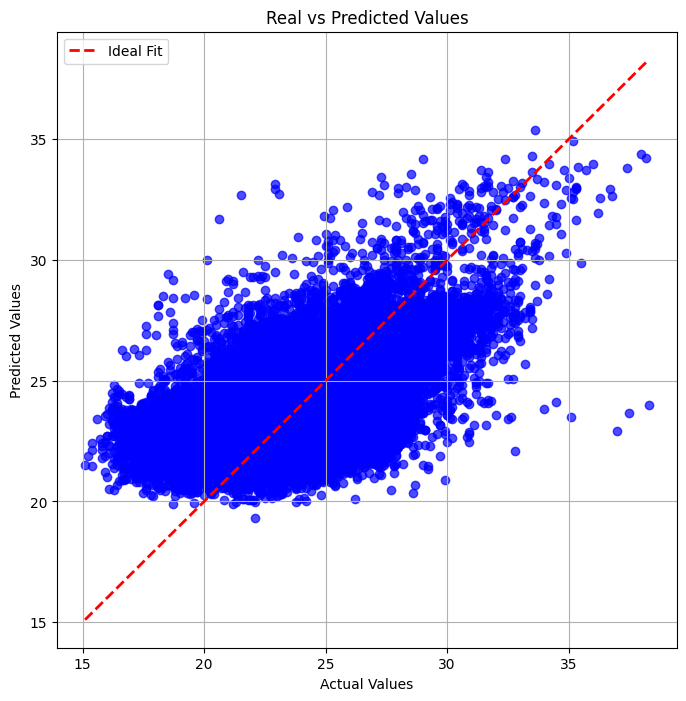

In [25]:
plot_real_vs_predicted(y_temp_test_flat, y_temp_pred_flat, save='./images/models/mlp_temp_real_x_pred.png')

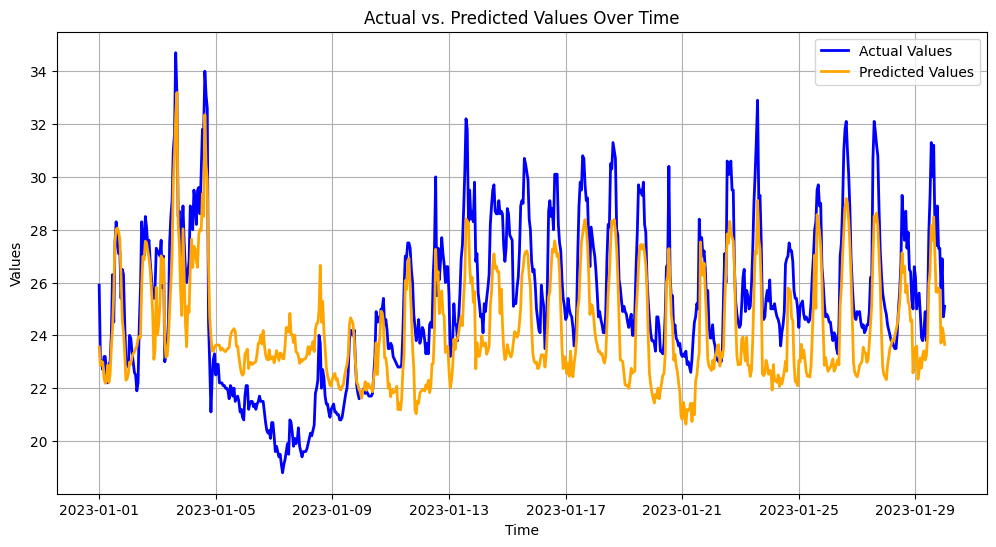

In [20]:
start_date = "2023-01-01"
end_date = "2023-01-30"

timestamps_test = df.iloc[round(df.shape[0] * 0.8):]["timestamp"]

plot_prediction_over_time(y_temp_test_flat, y_temp_pred_flat, timestamps_test, start_date, end_date, save='./images/models/mlp_temp_over_time.png')

## mlp precipitation

In [8]:
scaler_X = StandardScaler()
X_temp_normalized = scaler_X.fit_transform(X_prec)

scaler_y = StandardScaler()
y_temp_normalized = scaler_y.fit_transform(y_prec)

In [11]:
X_prec_train, X_prec_test, y_prec_train, y_prec_test = split_train_test(X_prec, y_prec, train_size=0.8)

In [12]:
model = tf.keras.Sequential([
    Dense(X_prec.shape[1], activation='relu', input_shape=(X_prec.shape[1], )),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

/usr/share/jupyter/kernels/tf-p3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-01-23 14:27:45.074653: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [14]:
tracker = EmissionsTracker(
    project_name="mlp PRECIPITATION 100ep final",
    output_file='./codecarbon_emissionsn.csv',
    log_level = "critical"
)

tracker.start()

model.compile(
    loss='mean_squared_error', 
    optimizer='adam',
    metrics=['mean_absolute_error']  
)

model.summary()

model.fit(X_prec_train, y_prec_train, epochs=100, batch_size=32, verbose=1)

loss, mae = model.evaluate(X_prec_test, y_prec_test, verbose=2)
print(f"Loss (MSE): {loss}")
print(f"Mean Absolute Error: {mae}")


rmse = np.sqrt(loss)
print(f"Root Mean Squared Error (RMSE): {rmse}")


emissions: float = tracker.stop()
print(f"emissions={emissions}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 849 (3.32 KB)

 Trainable params: 849 (3.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
3629/3629 ━━━━━━━━━━━━━━━━━━━━ 4s 924us/step - loss: 1.2637 - mean_absolute_error: 0.3020
Epoch 2/100
3629/3629 ━━━━━━━━━━━━━━━━━━━━ 3s 896us/step - loss: 1.1402 - mean_absolute_error: 0.2559
Epoch 3/100
3629/3629 ━━━━━━━━━━━━━━━━━━━━ 3s 885us/step - loss: 0.9927 - mean_absolute_error: 0.2454
Epoch 4/100
3629/3629 ━━━━━━━━━━━━━━━━━━━━ 3s 904us/step - loss: 1.0243 - mean_absolute_error: 0.2428
Epoch 5/100
3629/3629 ━━━━━━━━━━━━━━━━━━━━ 3s 895us/step - loss: 1.1069 - mean_absolute_error: 0.2365
Epoch 6/100
3629/3629 ━━━━━━━━━━━━━━━━━━━━ 3s 895us/step - loss: 1.2044 - mean_absolute_error: 0.2378
Epoch 7/100
3629/3629 ━━━━━━━━━━━━━━━━━━━━ 3s 883us/step - loss: 1.0225 - mean_absolute_error: 0.2279
Epoch 8/100
3629/3629 ━━━━━━━━━━━━━━━━━━━━ 3s 846us/step - loss: 1.1500 - mean_absolute_error: 0.2407
Epoch 9/100
3629/3629 ━━━━━━━━━━━━━━━━━━━━ 3s 911us/step - loss: 1.2068 - mean_absolute_error: 0.2355
Epoch 10/100
3629/3629 ━━━━━━━━━━━━━━━━━━━━ 3s 900us/step - loss: 1.1271 - mean_ab

In [15]:
rmse = np.sqrt(loss)
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 1.1510377886722651


In [12]:
y_prec_pred_probs = model.predict(X_prec_test, verbose=2)

908/908 - 1s - 567us/step


In [13]:
y_prec_test_flat = y_prec_test.values.flatten()
y_prec_pred_flat = y_prec_pred_probs.flatten()

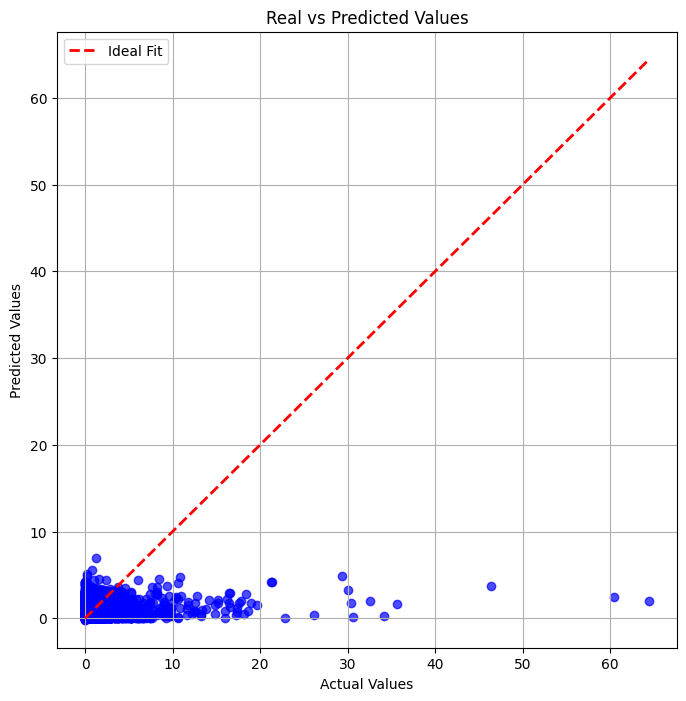

In [16]:
plot_real_vs_predicted(y_prec_test_flat, y_prec_pred_flat, save='./images/models/mlp_prec_real_x_pred.png')

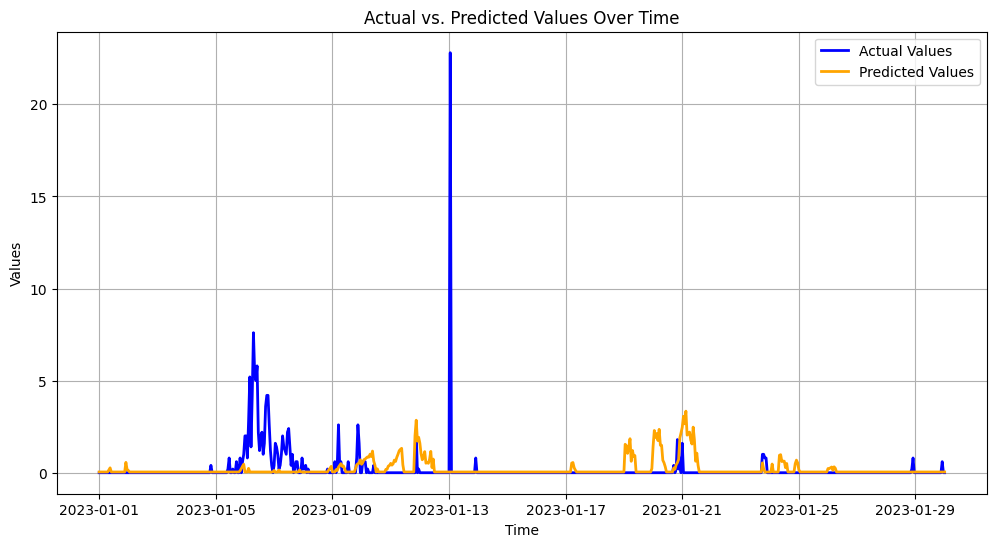

In [17]:
start_date = "2023-01-01"
end_date = "2023-01-30"

timestamps_test = df.iloc[round(df.shape[0] * 0.8):]["timestamp"]

plot_prediction_over_time(y_prec_test_flat, y_prec_pred_flat, timestamps_test, start_date, end_date,  save='./images/models/mlp_prec_over_time.png')